In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == 

# 1. Dataset Loading


In [ ]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from datasets import Dataset, DatasetDict
import torch


In [ ]:
# Load the dataset
df = pd.read_csv('Dataset-SA.csv')  # Replace with your actual filename

In [ ]:
df.head()

,product_name,product_price,Rate,Review,Summary,Sentiment
0,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,super!,great cooler excellent air flow and for this p...,positive
1,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,awesome,best budget 2 fit cooler nice cooling,positive
2,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,the quality is good but the power of air is de...,positive
3,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,1,useless product,very bad product its a only a fan,negative
4,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,ok ok product,neutral


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205052 entries, 0 to 205051
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   product_name   205052 non-null  object
 1   product_price  205052 non-null  object
 2   Rate           205052 non-null  object
 3   Review         180388 non-null  object
 4   Summary        205041 non-null  object
 5   Sentiment      205052 non-null  object
dtypes: object(6)
memory usage: 9.4+ MB


In [ ]:
df.describe()

,product_name,product_price,Rate,Review,Summary,Sentiment
count,205052,205052,205052,180388,205041,205052
unique,958,525,8,1324,92923,3
top,cello Pack of 18 Opalware Cello Dazzle Lush Fi...,1299,5,wonderful,good,positive
freq,6005,9150,118765,9016,17430,166581


Data Pre-Processing and EDA

In [ ]:
df['Rate'] = pd.to_numeric(df['Rate'], errors='coerce')
df.dropna(subset=['Review', 'Rate'], inplace=True)

In [ ]:
#Create 'Sentiment' column
def map_sentiment(rating):
    if rating >= 4:
        return "positive"
    elif rating <= 2:
        return "negative"
    else:
        return "neutral"

df['Sentiment'] = df['Rate'].apply(map_sentiment)


In [ ]:
# Select and rename columns
df = df[['Review', 'Sentiment']]
df.columns = ['text', 'label']

# Print label distribution
print(df['label'].value_counts())

label
positive    142616
negative     23745
neutral      14024
Name: count, dtype: int64


# MODEL1 BERT (80-20) rs=42

In [ ]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name, clean_up_tokenization_spaces=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Tokenize the text
tokenized_text = tokenizer(
    df['text'].tolist(),
    padding="max_length",
    truncation=True,
    max_length=128,  # Adjust if necessary
    return_tensors="pt"
)

In [ ]:
tokenized_data = df.copy()
tokenized_data['input_ids'] = [t.tolist() for t in tokenized_text['input_ids']]
tokenized_data['attention_mask'] = [t.tolist() for t in tokenized_text['attention_mask']]

In [ ]:
# Convert labels to numerical format (Important: AFTER tokenization)
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
tokenized_data['label'] = tokenized_data['label'].map(label_mapping)

In [ ]:
tokenized_datasets = Dataset.from_pandas(tokenized_data)

In [ ]:
# Split the data (using the original pandas DataFrame)
train_valid_df, test_df = train_test_split(tokenized_data, test_size=0.2, random_state=42) #No more stratification here as this is a pandas DataFrame.
train_df, valid_df = train_test_split(train_valid_df, test_size=0.1, random_state=42) #No more stratification here either.



In [ ]:
#Convert splits to Datasets. Create DatasetDict.
train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(valid_df)
test_dataset = Dataset.from_pandas(test_df)

data_dict = DatasetDict({'train':train_dataset, 'validation': valid_dataset, 'test': test_dataset}) #Combine Datasets into a DatasetDict.

In [ ]:
# Load the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,              # Adjust as needed
    per_device_train_batch_size=16,  # Adjust as needed
    per_device_eval_batch_size=64,   # Adjust as needed
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",  # Corrected argument name
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",      # Use weighted f1 for imbalanced data
    report_to="none"  # Disable WandB integration
    # push_to_hub=True,  # Uncomment if using Hugging Face Hub. Requires login.
    # push_to_hub_model_id="your-model-id" # Use your model id if push_to_hub=True. Requires login.
)


In [ ]:
# Define the evaluation metric calculation function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')  # Use weighted F1
    return {"accuracy": accuracy, "f1": f1}


In [ ]:
# Create the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data_dict['train'],  # Access train set from DatasetDict
    eval_dataset=data_dict['validation'],  # Access validation set from DatasetDict
    compute_metrics=compute_metrics  # Pass the metrics function
)

In [ ]:
# Train the model
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.025800,0.050951,0.986765,0.986629


TrainOutput(global_step=8118, training_loss=0.07197416559766669, metrics={'train_runtime': 3070.894, 'train_samples_per_second': 42.293, 'train_steps_per_second': 2.644, 'total_flos': 8543095338564864.0, 'train_loss': 0.07197416559766669, 'epoch': 1.0})

In [ ]:
# Evaluate the model on the test set
predictions = trainer.predict(data_dict['test']) #Make sure to pass a Dataset object to predict.
pred_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids
test_f1 = f1_score(true_labels, pred_labels, average='weighted')
test_accuracy = accuracy_score(true_labels, pred_labels)
print(f"Test F1: {test_f1}")
print(f"Test Accuracy: {test_accuracy}")


Test F1: 0.9844274618880668
Test Accuracy: 0.984616237492031


# MODEL2 DistillBERT(80-20)

In [ ]:
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['label'].map(label_mapping)

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenized = tokenizer(
    df['text'].tolist(),
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

# Add tokenized input to DataFrame
df['input_ids'] = tokenized['input_ids'].tolist()
df['attention_mask'] = tokenized['attention_mask'].tolist()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
train_valid_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, valid_df = train_test_split(train_valid_df, test_size=0.1, random_state=42)

train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(valid_df)
test_dataset = Dataset.from_pandas(test_df)

data_dict_distilbert = DatasetDict({
    "train": train_dataset,
    "validation": valid_dataset,
    "test": test_dataset
})

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# ------------------------
# 6. Training arguments
# ------------------------
training_args = TrainingArguments(
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_distilbert',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"accuracy": accuracy, "f1": f1}

# ------------------------
# 8. Trainer
# ------------------------
trainer_distilbert = Trainer(
    model=model,
    args=training_args,
    train_dataset=data_dict_distilbert['train'],
    eval_dataset=data_dict_distilbert['validation'],
    compute_metrics=compute_metrics
)

In [ ]:
trainer_distilbert.train()

predictions_distilbert = trainer_distilbert.predict(data_dict_distilbert['test'])
pred_labels_distilbert = np.argmax(predictions_distilbert.predictions, axis=-1)
true_labels_distilbert = predictions_distilbert.label_ids

# ------------------------
# 10. Final metrics
# ------------------------
test_f1_distilbert = f1_score(true_labels_distilbert, pred_labels_distilbert, average='weighted')
test_accuracy_distilbert = accuracy_score(true_labels_distilbert, pred_labels_distilbert)

print(f"DistilBERT Test Accuracy: {test_accuracy_distilbert:.4f}")
print(f"DistilBERT Test F1 Score: {test_f1_distilbert:.4f}")

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.026300,0.050480,0.986626,0.986487


DistilBERT Test Accuracy: 0.9845
DistilBERT Test F1 Score: 0.9843


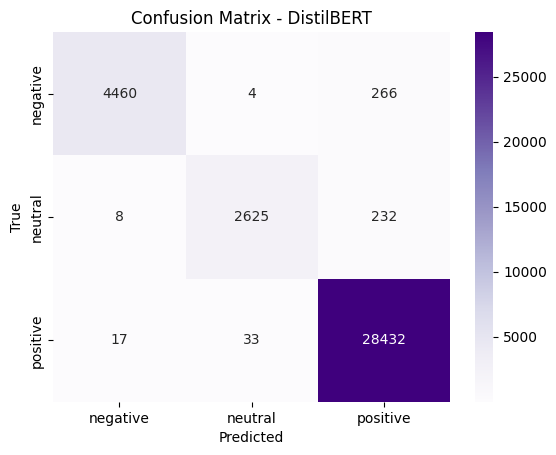

In [ ]:
conf_matrix_distilbert = confusion_matrix(true_labels_distilbert, pred_labels_distilbert)

sns.heatmap(conf_matrix_distilbert, annot=True, fmt='d', cmap='Purples',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])

plt.title('Confusion Matrix - DistilBERT')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# MODEL3 DistillBERT(70-30, 60-40)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'true_labels_bert' and 'pred_labels_bert' contain the true and predicted labels for BERT
# Similarly, 'true_labels_distilbert' and 'pred_labels_distilbert' contain the true and predicted labels for DistilBERT

# Confusion matrix for BERT
conf_matrix_bert = confusion_matrix(true_labels, pred_labels)

# Confusion matrix for DistilBERT
conf_matrix_distilbert = confusion_matrix(true_labels_distilbert, pred_labels_distilbert)

# Plot for BERT
plt.figure(figsize=(12, 6))

# BERT Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_bert, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.title('Confusion Matrix - BERT')
plt.xlabel('Predicted')
plt.ylabel('True')

# DistilBERT Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_distilbert, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.title('Confusion Matrix - DistilBERT')
plt.xlabel('Predicted')
plt.ylabel('True')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

# Option C: 70% train, 30% test
train_c_df, test_c_df = train_test_split(df, test_size=0.3, random_state=42)
train_c, val_c = train_test_split(train_c_df, test_size=0.1, random_state=42)

# Option D: 60% train, 40% test
train_d_df, test_d_df = train_test_split(df, test_size=0.4, random_state=42)
train_d, val_d = train_test_split(train_d_df, test_size=0.1, random_state=42)


In [ ]:
from datasets import Dataset, DatasetDict

# Convert to DatasetDicts
data_dict_c = DatasetDict({
    'train': Dataset.from_pandas(train_c),
    'validation': Dataset.from_pandas(val_c),
    'test': Dataset.from_pandas(test_c_df)
})

data_dict_d = DatasetDict({
    'train': Dataset.from_pandas(train_d),
    'validation': Dataset.from_pandas(val_d),
    'test': Dataset.from_pandas(test_d_df)
})


In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

model_name = "distilbert-base-uncased"

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='weighted')
    }


In [ ]:
def train_distilbert(data_dict, output_dir):
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=1,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        report_to="none",
        logging_dir=f"{output_dir}/logs",
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=data_dict['train'],
        eval_dataset=data_dict['validation'],
        compute_metrics=compute_metrics
    )

    trainer.train()
    return trainer


In [ ]:
def evaluate_distilbert(trainer, dataset):
    predictions = trainer.predict(dataset)
    preds = np.argmax(predictions.predictions, axis=-1)
    labels = predictions.label_ids
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return f1, acc


In [ ]:
# Option C
trainer_c = train_distilbert(data_dict_c, "./distilbert_c_results")
f1_c, acc_c = evaluate_distilbert(trainer_c, data_dict_c['test'])

# Option D
trainer_d = train_distilbert(data_dict_d, "./distilbert_d_results")
f1_d, acc_d = evaluate_distilbert(trainer_d, data_dict_d['test'])

print(f"Option C - F1: {f1_c:.4f}, Accuracy: {acc_c:.4f}")
print(f"Option D - F1: {f1_d:.4f}, Accuracy: {acc_d:.4f}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.055100,0.048057,0.986537,0.986388


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.051700,0.056134,0.984387,0.984210


Option C - F1: 0.9848, Accuracy: 0.9850
Option D - F1: 0.9849, Accuracy: 0.9850


In [ ]:
print(f"DistilBERT Test Accuracy: {test_accuracy_distilbert:.6f}")
print(f"DistilBERT Test F1 Score: {test_f1_distilbert:.6f}")
DistilBERT Test Accuracy: 0.985420
DistilBERT Test F1 Score: 0.985266

DistilBERT Test Accuracy: 0.984478
DistilBERT Test F1 Score: 0.984287


# Comparision for different dataset splits

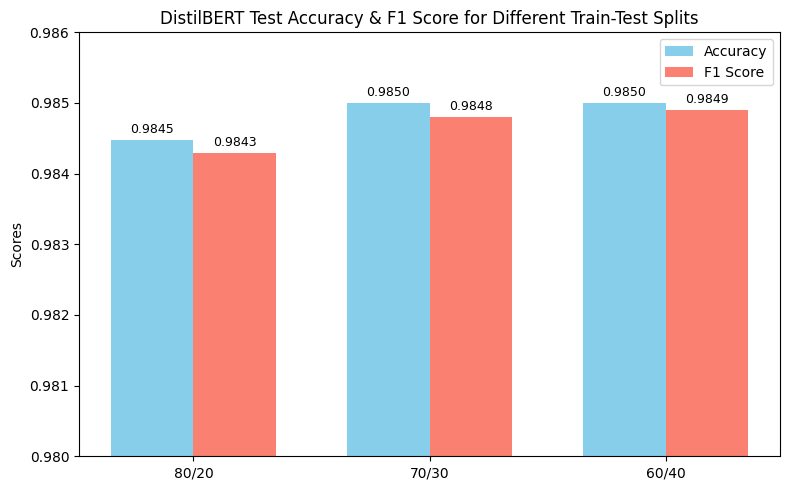

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Results you provided
splits = ['80/20', '70/30', '60/40']
f1_scores = [0.984287, 0.9848, 0.9849]
accuracies = [0.984478, 0.9850, 0.9850]

x = np.arange(len(splits))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, accuracies, width, label='Accuracy', color='skyblue')
bars2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score', color='salmon')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('DistilBERT Test Accuracy & F1 Score for Different Train-Test Splits')
ax.set_xticks(x)
ax.set_xticklabels(splits)
ax.set_ylim(0.98, 0.986)
ax.legend()

# Annotate values on top
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


MODEL4 DistillBERT for Random State set to false

<ipython-input-2-1d79c0c9af71>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].map(label_mapping)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.030900,0.056596,0.984755,0.984594


DistilBERT Test Accuracy: 0.985420
DistilBERT Test F1 Score: 0.985266


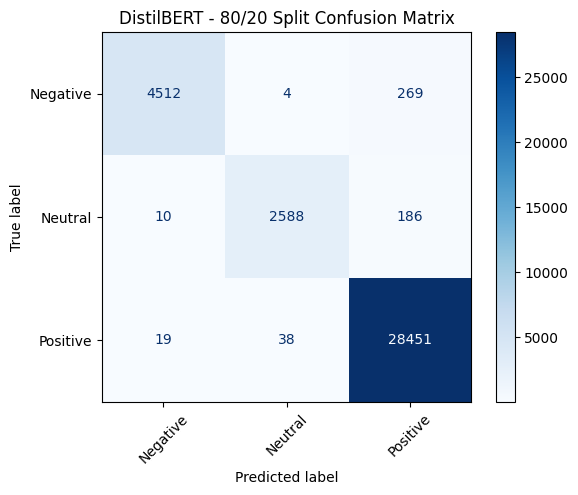

In [ ]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from datasets import Dataset, DatasetDict
import torch
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("Dataset-SA.csv")

# Preprocess: Clean Rate and Drop NA
df['Rate'] = pd.to_numeric(df['Rate'], errors='coerce')
df.dropna(subset=['Review', 'Rate'], inplace=True)

# Create Sentiment label
def map_sentiment(rating):
    if rating >= 4:
        return "positive"
    elif rating <= 2:
        return "negative"
    else:
        return "neutral"

df['Sentiment'] = df['Rate'].apply(map_sentiment)
df = df[['Review', 'Sentiment']]
df.columns = ['text', 'label']

# Convert labels to numeric
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['label'].map(label_mapping)

# Tokenize
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenized = tokenizer(
    df['text'].tolist(),
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

df['input_ids'] = [ids.tolist() for ids in tokenized['input_ids']]
df['attention_mask'] = [mask.tolist() for mask in tokenized['attention_mask']]

# 80/20 split WITHOUT random seed (random_state=None)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=None)
train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=None)  # 10% of train for validation

# Convert to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
valid_dataset = Dataset.from_pandas(valid_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

data_dict = DatasetDict({
    "train": train_dataset,
    "validation": valid_dataset,
    "test": test_dataset
})

# Load model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results_distilbert_80_20",
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs_distilbert_80_20",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

# Metrics
def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data_dict["train"],
    eval_dataset=data_dict["validation"],
    compute_metrics=compute_metrics
)

# Train
trainer.train()

# Evaluate on test set
test_preds = trainer.predict(data_dict["test"])
pred_labels = np.argmax(test_preds.predictions, axis=1)
true_labels = test_preds.label_ids

# Final metrics
test_accuracy = accuracy_score(true_labels, pred_labels)
test_f1 = f1_score(true_labels, pred_labels, average="weighted")
print(f"DistilBERT Test Accuracy: {test_accuracy:.6f}")
print(f"DistilBERT Test F1 Score: {test_f1:.6f}")

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("DistilBERT - 80/20 Split Confusion Matrix")
plt.show()


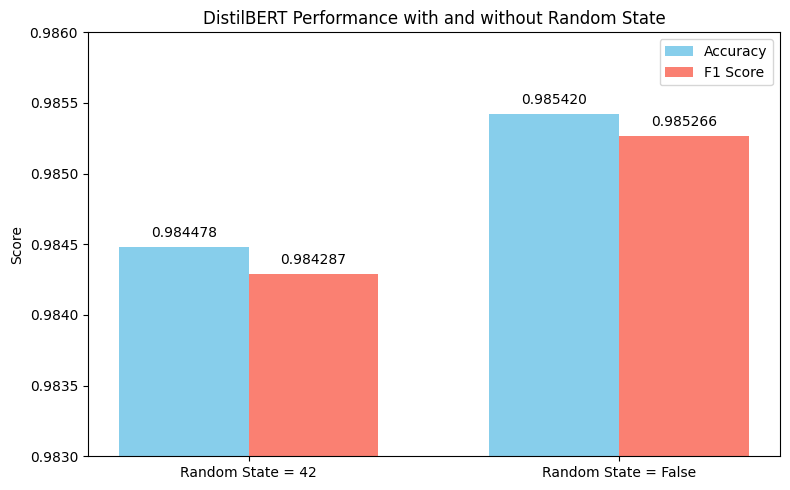

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Labels for the configurations
labels = ['Random State = 42', 'Random State = False']

# Metrics
accuracy = [0.984478, 0.985420]
f1_score = [0.984287, 0.985266]

x = np.arange(len(labels))  # label locations
width = 0.35  # width of the bars

# Create subplots
fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, accuracy, width, label='Accuracy', color='skyblue')
rects2 = ax.bar(x + width/2, f1_score, width, label='F1 Score', color='salmon')

# Add labels, title, and legend
ax.set_ylabel('Score')
ax.set_title('DistilBERT Performance with and without Random State')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([0.983, 0.986])
ax.legend()

# Add text labels above bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.6f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()
